# Theory

## Model

The Duckworth-Lewis-Stern (DLS) method uses the following function to model the expected remaining runs:

$$Z(u, w) = Z_0(w)[1 - exp\{-L(w)u/Z_0(w)\}]$$  

Where:
- $Z(u, w)$ is the expected number of runs to be scored in the remaining $u$ overs with $w$ wickets in hand
- $Z_0(w)$ is the asymptotic value of $Z(u, w)$ as $u$ approaches infinity (theoretical maximum score with $w$ wickets in hand)
- $L(w)$ is the rate at which $Z(u, w)$ approaches its asymptote $Z_0(w)$, representing: 
    - Run-scoring rate: Initial run-scoring rate when many overs remain 
    - Wicket-dependency: Varies based on wickets in hand (w) 
    - Acceleration factor: Higher $L(w)$ means faster approach to $Z_0(w)$ 
    - Risk vs. conservation: Balances aggressive scoring and wicket preservation  
    - Strategy indicator: Reflects team's approach (higher $L(w)$ = more aggressive)  
    - Model flexibility: Allows capturing different behaviors for various game states 
- $u$ is the number of overs remaining
- $w$ is the number of wickets in hand

This function captures the non-linear relationship between runs scored and overs remaining, accounting for wickets in hand.


## Model Fitting Process

To fit our ODI data from the CSV file to the Duckworth-Lewis-Stern (DLS) model, we will be estimating the following parameters:

1. $Z_0(w)$ for $w = 1$ to $10$: These represent the asymptotic values of the expected remaining runs for each wicket in hand scenario. We need to estimate 10 different $Z_0$ values.

2. $L(w)$ for $w = 1$ to $10$: These are the rate parameters at which $Z(u,w)$ approaches its asymptote $Z_0(w)$ for each wicket scenario. We need to estimate 10 different $L$ values, one for each wicket in hand. 

# Preliminaries

The data ODI over-by-over data (.csv file) contains data on ODI matches from 1999 to 2011

In [64]:
import os  # For operating system related operations
import pickle  # For serializing and deserializing Python objects
import numpy as np  # For numerical operations and array manipulations
import scipy as sp  # For scientific computing and optimization
import pandas as pd  # For data manipulation and analysis
import matplotlib.pyplot as plt  # For creating static, animated, and interactive visualizations
from typing import List, Union  # For type hinting and improved code readability
from scipy.optimize import minimize  # For optimization tasks, specifically minimizing functions
import time  # Import time module for timing
import matplotlib.pyplot as plt  # Importing the matplotlib library for plotting

# Get data

In [3]:
def get_data(data_path) -> Union[pd.DataFrame, np.ndarray]:
    """
    Loads the data from the given path and returns a pandas dataframe.

    Args:
        path (str): Path to the data file.

    Returns:
        pd.DataFrame, np.ndarray: Data Structure containing the loaded data
    """
    data_path = os.path.join(os.getcwd(), '04_cricket_1999to2011.csv')  # Construct the full path using the relative path
    data = pd.read_csv(data_path)  # Read the CSV file into a pandas DataFrame
    return data  # Return the loaded data as a pandas DataFrame

# Preprocess data


This preprocessing function focuses on the essential columns for fitting the DLS model:

1. Overs.Remaining: Calculated from 'Total.Overs' and 'Over'
2. Wickets.in.Hand: Directly used from the original data
3. Z: Calculated as the difference between 'Innings.Total.Runs' and 'Total.Runs'
4. Match: Kept for potential grouping or validation purposes

These columns provide all the necessary information to fit the DLS model and estimate the 10 values of $Z_0$ and $L$. The function removes any unnecessary data, handles potential errors, and prepares a clean dataset focused on these key variables for model training.

In [16]:
def preprocess_data(data: Union[pd.DataFrame, np.ndarray]) -> Union[pd.DataFrame, np.ndarray]:
    """
    Preprocesses the dataframe by selecting relevant columns, calculating required values,
    filtering for first innings data only, and cleaning the data for model training.

    Args:
        data (pd.DataFrame, nd.ndarray): Pandas dataframe containing the loaded data

    Returns:
        pd.DataFrame, np.ndarray: Datastructure containing the cleaned first innings data.
    """
    # Select relevant columns
    relevant_columns = ['Match', 'Innings', 'Over', 'Total.Runs', 'Innings.Total.Runs', 'Total.Overs', 'Wickets.in.Hand']
    data = data[relevant_columns]  # Keep only the selected columns

    # Filter for first innings data only
    data = data[data['Innings'] == 1]  # Keep only the first innings data

    # Calculate overs remaining
    data['Overs.Remaining'] = data['Total.Overs'] - data['Over']  # Calculate overs remaining for each row

    # Remove rows with missing values
    data = data.dropna()  # Remove any rows with missing data

    # Filter out potentially erroneous data
    data = data[(data['Wickets.in.Hand'] >= 0) & (data['Wickets.in.Hand'] <= 10)]  # Ensure wickets in hand is between 0 and 10
    data = data[data['Overs.Remaining'] >= 0]  # Ensure overs remaining is non-negative

    # Calculate Z(u,w) - the runs scored from this point onwards
    data['Z'] = data['Innings.Total.Runs'] - data['Total.Runs']  # Calculate Z as the runs scored from this point to the end of innings

    # Sort the data by Match and Over for consistency
    data = data.sort_values(['Match', 'Over'])  # Sort data for consistency and easier analysis

    # Select final columns for model training
    final_columns = ['Match', 'Overs.Remaining', 'Wickets.in.Hand', 'Z']  # Select the columns we'll use for model training
    data = data[final_columns]  # Keep only these final columns

    return data  # Return the preprocessed data

In [17]:
# Print all columns with head name and a few rows after preprocessing
preprocessed_data = preprocess_data(data)  # Assuming 'data' is the original dataset
print("Columns and first few rows of preprocessed data:")
print(preprocessed_data.head().to_string())  # Print all columns and first few rows as a string
print("\nDataset shape:", preprocessed_data.shape)  # Print the shape of the preprocessed dataset
print("\nColumn names:", list(preprocessed_data.columns))  # Print the list of column names
print("\nData types of columns:")
print(preprocessed_data.dtypes)  # Print the data types of each column


Columns and first few rows of preprocessed data:
      Match  Overs.Remaining  Wickets.in.Hand    Z
6107  64725               49               10  359
6108  64725               48               10  351
6109  64725               47               10  347
6110  64725               46               10  330
6111  64725               45               10  320

Dataset shape: (67794, 4)

Column names: ['Match', 'Overs.Remaining', 'Wickets.in.Hand', 'Z']

Data types of columns:
Match              int64
Overs.Remaining    int64
Wickets.in.Hand    int64
Z                  int64
dtype: object


# Define model

The DLModel class represents the Duckworth-Lewis model for predicting cricket scores.
 It has a total of 20 learnable parameters:
 - 10 parameters for Z0 (one for each wicket in hand, from 1 to 10)
 - 10 parameters for L (one for each wicket in hand, from 1 to 10)
 These parameters are used in the DL formula to predict the expected runs (Z) 
 based on overs remaining (X) and wickets in hand (w).

In [44]:
class DLModel:
    """
    Model Class to approximate the Z function as defined in the assignment.
    """

    def __init__(self):
        """Initialize the model with default parameters."""
        self.Z0 = [300, 280, 260, 240, 220, 200, 180, 160, 140, 120]  # Initialize Z0 with default values for each wicket (10 parameters)
        self.L = [0.05, 0.06, 0.07, 0.08, 0.09, 0.10, 0.11, 0.12, 0.13, 0.14]  # Initialize L with default values for each wicket (10 parameters)

    def get_prediction(self, overs_remaining: float, wickets_in_hand: int) -> float:
        """
        Get the prediction for the expected remaining runs using the DL model formula.

        Args:
            overs_remaining (float): Number of overs remaining in the innings.
            wickets_in_hand (int): Number of wickets currently in hand (1-10).

        Returns:
            float: Predicted expected remaining runs.
        """
        if not 1 <= wickets_in_hand <= 10:
            raise ValueError("Wickets in hand must be between 1 and 10.")
        
        Z_0 = self.Z0[wickets_in_hand - 1]  # Select Z0 value for given wickets in hand
        L = self.L[wickets_in_hand - 1]  # Select L value for given wickets in hand
        
        return Z_0 * (1 - np.exp(-L * overs_remaining / Z_0))  # Apply DL formula and return scalar result

# Loss function


In [40]:
def calculate_loss(model: DLModel, data: Union[pd.DataFrame, np.ndarray]) -> float:
    '''
    Calculates the normalised loss for the given model and data using the specified loss function.

    Args:
        model (DLModel): Trained model
        data (pd.DataFrame or np.ndarray): Data to calculate the loss on
    
    Returns:
        float: Normalised loss for the given model and data
    '''
    relevant_columns = ['Overs.Remaining', 'Wickets.in.Hand', 'Z']  # Define relevant columns for calculation
    data = data[relevant_columns]  # Filter data to include only relevant columns

    total_loss = 0.0  # Initialize total loss to zero
    total_points = 0  # Initialize total number of data points to zero

    for w in range(1, 11):  # Iterate through wickets from 1 to 10
        wicket_data = data[data['Wickets.in.Hand'] == w]  # Filter data for current wicket
        X = wicket_data['Overs.Remaining'].values  # Get overs remaining
        y = wicket_data['Z'].values  # Get actual runs to go

        y_pred = np.array([model.get_prediction(x, w) for x in X])  # Get model predictions for current wicket and overs remaining

        # Calculate loss for each data point using the specified loss function
        # Add small epsilon to avoid divide by zero
        epsilon = 1e-10
        point_losses = (y_pred + 1) * np.log((y_pred + 1) / (y + 1 + epsilon)) - y_pred + y

        total_loss += np.sum(point_losses)  # Sum losses for all points
        total_points += len(y)  # Increment total number of points

    normalised_loss = total_loss / total_points  # Normalize loss by total number of points

    return normalised_loss  # Return the normalized loss

In [41]:
model = DLModel()  # Create an instance of the DLModel with default parameters

# Load and preprocess the data
data_path = '../data/04_cricket_1999to2011.csv'  # Define the path to the data file
data = get_data(data_path)  # Load the data from CSV file
preprocessed_data = preprocess_data(data)  # Preprocess the loaded data

# Calculate the loss using the calculate_loss function
loss = calculate_loss(model, preprocessed_data)  # Calculate the loss for the model and preprocessed data

print(f"The normalized loss for the model is: {loss:.4f}")  # Print the calculated loss with 4 decimal places

The normalized loss for the model is: 114.1069


# Training the model


In [58]:
def train_model(data: Union[pd.DataFrame, np.ndarray], model: DLModel, max_iterations: int = 1000, patience: int = 50) -> DLModel:
    """Trains the model using optimization techniques to find optimal parameters"""
    
    start_time = time.time()
    iteration_count = 0
    best_loss = float('inf')
    iterations_without_improvement = 0
    
    def objective(params):
        nonlocal iteration_count, best_loss, iterations_without_improvement
        model.Z0 = params[:10].tolist()
        model.L = params[10:].tolist()
        loss = calculate_loss(model, data)
        
        iteration_count += 1
        if loss < best_loss:
            best_loss = loss
            iterations_without_improvement = 0
        else:
            iterations_without_improvement += 1
        
        if iteration_count % 10 == 0:
            elapsed_time = time.time() - start_time
            print(f"Iteration {iteration_count}: Loss = {loss:.4f}, Best Loss = {best_loss:.4f}, Time elapsed: {elapsed_time:.2f} seconds")
            print(f"Z0: {model.Z0}")
            print(f"L: {model.L}")
        
        return loss

    initial_params = np.array(model.Z0 + model.L)
    bounds = [(0, None)] * 20

    print("Starting optimization...")
    result = minimize(objective, initial_params, method='L-BFGS-B', bounds=bounds, 
                      options={'maxiter': max_iterations, 'ftol': 1e-6, 'gtol': 1e-6})

    model.Z0 = result.x[:10].tolist()
    model.L = result.x[10:].tolist()

    total_time = time.time() - start_time
    print(f"\nOptimization completed in {total_time:.2f} seconds")
    print(f"Final loss: {result.fun:.4f}")
    print(f"Total iterations: {iteration_count}")
    print(f"Optimization successful: {result.success}")
    print(f"Optimization message: {result.message}")

    return model

In [59]:
trained_model = train_model(preprocessed_data, model, max_iterations=1000, patience=50)  # Train the model using the preprocessed data with a maximum of 1000 iterations and a patience of 50 iterations for early stopping

Starting optimization...
Iteration 10: Loss = 6.3378, Best Loss = 6.3378, Time elapsed: 3.19 seconds
Z0: [6.279750597937215, 18.224296724778146, 39.450922613573816, 62.272935367146864, 80.2097053825061, 129.04124381623282, 160.87777108379768, 188.8734361841017, 211.70731724067926, 226.31938406583205]
L: [5.856575260991422, 12.53867169365049, 10.575912208387562, 10.526697155397986, 12.807087079167916, 10.83427279183342, 10.401760103813066, 11.496963854577732, 12.166702690999573, 16.610921794537013]
Iteration 20: Loss = 6.3378, Best Loss = 6.3378, Time elapsed: 6.29 seconds
Z0: [6.279750597937215, 18.224296724778146, 39.450922613573816, 62.272935367146864, 80.2097053825061, 129.04124381623282, 160.87777108379768, 188.8734361841017, 211.70731723067925, 226.31938406583205]
L: [5.856575260991422, 12.53867169365049, 10.575912208387562, 10.526697155397986, 12.807087079167916, 10.83427279183342, 10.401760103813066, 11.496963854577732, 12.166702700999574, 16.610921794537013]
Iteration 30: Loss 

# Print model parameters

In [60]:
def print_model_params(model: DLModel) -> List[float]:  # Define a function to print model parameters, taking a trained model as input
    '''
    Prints the 11 (Z_0(1), ..., Z_0(10), L) model parameters

    Args:
        model (DLModel): Trained model  # Specify that the input is a trained DLModel instance
    
    Returns:
        array: 11 model parameters (Z_0(1), ..., Z_0(10), L)  # Indicate that the function returns a list of model parameters
    '''
    
    model_parameters = model.Z0 + model.L  # Combine the Z0 and L parameters from the model into a single list
    print("Model Parameters:")  # Print a header for clarity
    for index, parameter in enumerate(model_parameters):  # Iterate over the model parameters with their indices
        print(f"Parameter {index + 1}: {parameter}")  # Print each parameter with its corresponding index
    return model_parameters  # Return the list of model parameters

In [63]:
print("Optimized Model Parameters:")  # Print a header indicating the start of optimized model parameters output
optimized_model_parameters = model.Z0 + model.L  # Combine the optimized Z0 and L parameters from the model into a single list
for index, parameter in enumerate(optimized_model_parameters):  # Iterate over the optimized model parameters with their indices
    print(f"Optimized Parameter {index + 1}: {parameter}")  # Print each optimized parameter with its corresponding index


Optimized Model Parameters:
Optimized Parameter 1: 6.044916767187038
Optimized Parameter 2: 19.003637848803447
Optimized Parameter 3: 40.38546153567663
Optimized Parameter 4: 67.09323502928348
Optimized Parameter 5: 92.19787493519819
Optimized Parameter 6: 123.04316481432966
Optimized Parameter 7: 156.38400735683717
Optimized Parameter 8: 194.91171392234116
Optimized Parameter 9: 220.22342570818654
Optimized Parameter 10: 273.77575035674573
Optimized Parameter 11: 6.190767193667891
Optimized Parameter 12: 7.9960518164556
Optimized Parameter 13: 10.18084309741621
Optimized Parameter 14: 10.153234958555021
Optimized Parameter 15: 10.430875306058175
Optimized Parameter 16: 11.117044129371036
Optimized Parameter 17: 10.797185025125838
Optimized Parameter 18: 10.779020814975052
Optimized Parameter 19: 11.348249389701035
Optimized Parameter 20: 10.640696476327252


# Plots

In [70]:
def plot(model: DLModel) -> None:  # Define a function to plot model predictions for different wickets in hand
    """ Plots the model predictions against the number of overs
        remaining for each wicket in hand.

    Args:
        model (DLModel): Trained model  # Specify that the input is a trained DLModel instance
    """
    overs_remaining = list(range(1, 51))  # Create a list of overs remaining from 1 to 50
    plt.figure(figsize=(12, 8))  # Create a new figure for the plot with specified size

    for wickets in range(1, 11):  # Iterate through all possible wickets in hand (1 to 10)
        predictions = [model.get_prediction(over, wickets) for over in overs_remaining]  # Get model predictions for each over using get_prediction method
        plt.plot(overs_remaining, predictions, marker='', linestyle='-', label=f'{wickets} wicket(s)')  # Plot predictions for each wicket count

    plt.title('Model Predictions vs. Overs Remaining for Different Wickets in Hand')  # Set the title of the plot
    plt.xlabel('Overs Remaining')  # Label the x-axis
    plt.ylabel('Runs yet to be scored from that point forward')  # Label the y-axis
    plt.legend(title='Wickets in Hand', loc='center left', bbox_to_anchor=(1, 0.5))  # Add a legend to the plot outside the main plot area
    plt.grid(True)  # Enable grid for better readability
    plt.tight_layout()  # Adjust the layout to prevent clipping of labels
    plt.show()  # Display the plot

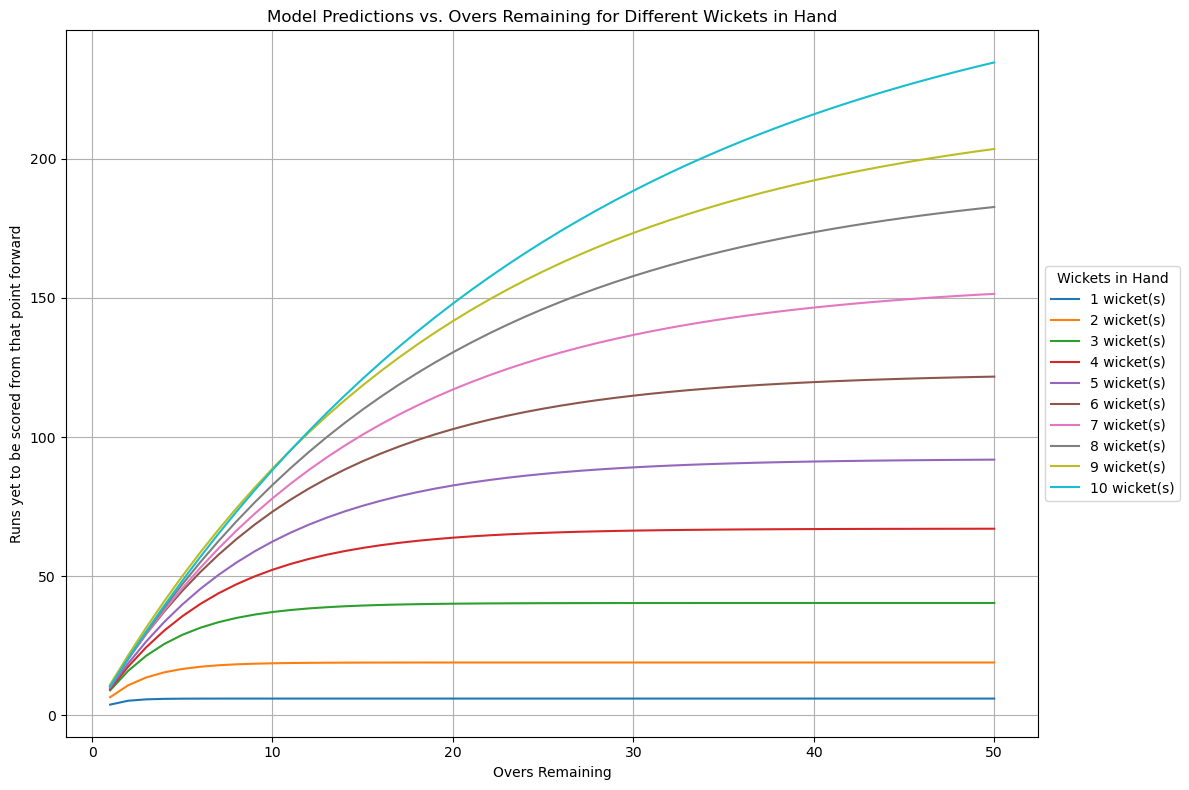

The plot shows the model's predictions for different numbers of overs remaining.
The x-axis represents the number of overs remaining, ranging from 1 to 10.
The y-axis represents the predicted value from the model.
Each point on the plot corresponds to a specific prediction for a given number of overs remaining.
The line connecting the points shows the trend of predictions as overs remaining changes.

Interpretation:
- Observe how the predicted value changes as the number of overs remaining increases.
- Look for any patterns or anomalies in the predictions.
- Consider how this information might be useful in a cricket match scenario.


In [71]:
# Call the plot function to visualize the model predictions
plot(model)  # Visualize the trained model's predictions against overs remaining

# Display additional information about the plot
print("The plot shows the model's predictions for different numbers of overs remaining.")  # Provide context for the plot
print("The x-axis represents the number of overs remaining, ranging from 1 to 10.")  # Explain the x-axis of the plot
print("The y-axis represents the predicted value from the model.")  # Explain the y-axis of the plot
print("Each point on the plot corresponds to a specific prediction for a given number of overs remaining.")  # Describe what each point represents
print("The line connecting the points shows the trend of predictions as overs remaining changes.")  # Explain the significance of the line in the plot

# Encourage interpretation of the plot
print("\nInterpretation:")  # Header for interpretation section
print("- Observe how the predicted value changes as the number of overs remaining increases.")  # Prompt to analyze the trend
print("- Look for any patterns or anomalies in the predictions.")  # Suggest looking for interesting features in the plot
print("- Consider how this information might be useful in a cricket match scenario.")  # Relate the plot to practical applications


# Common slope L

In [76]:
# Get the weights of the wickets and print them
wicket_weights = model.Z0  # Retrieve the Z0 values from the trained model

print("Weights of the wickets:")
for i, weight in enumerate(wicket_weights, start=1):
    print(f"Wicket {i}: {weight:.4f}")  # Print each wicket's weight with 4 decimal places

Weights of the wickets:
Wicket 1: 6.0449
Wicket 2: 19.0036
Wicket 3: 40.3855
Wicket 4: 67.0932
Wicket 5: 92.1979
Wicket 6: 123.0432
Wicket 7: 156.3840
Wicket 8: 194.9117
Wicket 9: 220.2234
Wicket 10: 273.7758


In [78]:
# Calculate the weighted average of L values
weighted_L = sum(weight * L for weight, L in zip(wicket_weights, model.L)) / sum(wicket_weights)  # Calculate weighted average of L values using wicket weights and model L values

print(f"\nWeighted average L: {weighted_L:.4f}")  # Print the weighted average L value with 4 decimal places


Weighted average L: 10.7344


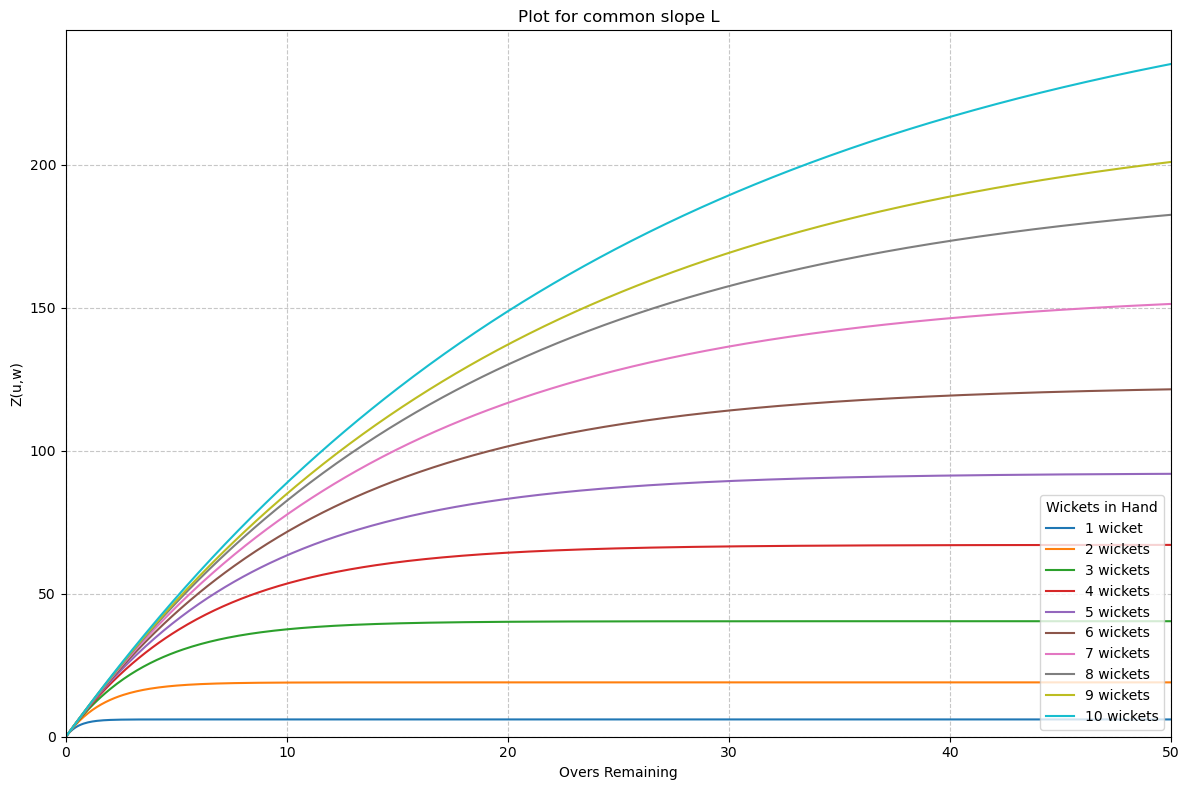

In [81]:
# Create a new figure with specified size
plt.figure(figsize=(12, 8))

# Define the range of overs remaining
overs_remaining = np.linspace(0, 50, 500)

# Define the Z0 values for each wicket
Z0 = [6.044916767187038, 19.003637848803447, 40.38546153567663, 67.09323502928348, 92.19787493519819, 
      123.04316481432966, 156.38400735683717, 194.91171392234116, 220.22342570818654, 273.77575035674573]

# Define the weighted average L
L = 10.7344

# Plot a curve for each wicket
for w in range(1, 11):
    Z = Z0[w-1] * (1 - np.exp(-L * overs_remaining / Z0[w-1]))  # Calculate Z values using the given formula
    plt.plot(overs_remaining, Z, label=f'{w} wicket{"s" if w > 1 else ""}')  # Plot the curve and add label

# Customize the plot
plt.xlabel('Overs Remaining')  # Set x-axis label
plt.ylabel('Z(u,w)')  # Set y-axis label
plt.title('Plot for common slope L')  # Set plot title
plt.legend(title='Wickets in Hand', loc='lower right')  # Add legend with title
plt.grid(True, linestyle='--', alpha=0.7)  # Add grid lines
plt.xlim(0, 50)  # Set x-axis limits
plt.ylim(0, None)  # Set y-axis lower limit to 0

# Show the plot
plt.tight_layout()  # Adjust layout
plt.show()  # Display the plot

# Main

In [ ]:
def main(args):
    """Main Function"""

    data = get_data(args['data_path'])  # Loading the data from the specified path
    print("Data loaded.")  # Inform user that data has been loaded
    
    data = preprocess_data(data)  # Preprocess the loaded data
    print("Data preprocessed.")  # Inform user that data has been preprocessed
    
    model = DLModel()  # Initialize the DLModel
    model = train_model(data, model)  # Train the model using the preprocessed data
    print("Model trained.")  # Inform user that model has been trained
    
    params = print_model_params(model)  # Get and print the model parameters
    print("Model parameters:", params)  # Display the model parameters
    
    plot(model, args['plot_path'])  # Generate and save the plot
    print("Plot generated and saved.")  # Inform user that plot has been generated and saved